In [1]:
import gzip
import theano
import cPickle
import matplotlib
import numpy as np
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline


with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = cPickle.load(f)
    

def shared_dataset(data_xy):
    data_x, data_y = data_xy
    return theano.shared(data_x), theano.shared(data_y)


test_set_x, test_set_y = shared_dataset(test_set)
valid_set_x, valid_set_y = shared_dataset(valid_set)
train_set_x, train_set_y = shared_dataset(train_set)
batch_size = 500
train_data_set_size = len(train_set[0])

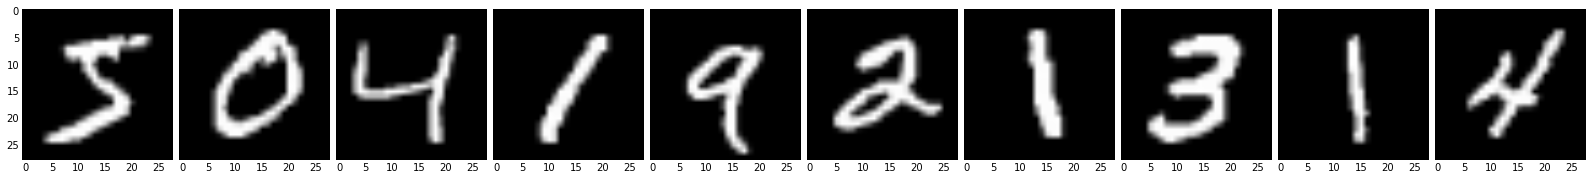

In [2]:
fig = plt.figure(1, (28., 28.))
grid = ImageGrid(fig, 111, nrows_ncols = (1, 10), axes_pad=0.1)

for c in range(10):
    image_array = train_set[0][c].reshape((28, 28))
    grid[c].imshow(image_array, cmap=plt.cm.gray)

In [5]:
from theano import tensor as T


def rectify(x):
    return T.maximum(x, 0.)


class DenseLayer(object):
    def __init__(self, w_init):
        self.W = theano.shared(w_init())
        
    def get_output_expr(self, input_expr):
        pre_rectify_expr = T.dot(input_expr, self.W)
        return rectify(pre_rectify_expr)

    def get_parameters(self):
        return [self.W]
    

class LogisticRegresion(object):
    def __init__(self, w_init):
        self.W = theano.shared(w_init())
        
    def get_output_expr(self, input_expr):
        pre_softmax_expr = T.dot(input_expr, self.W)
        return T.nnet.softmax(pre_softmax_expr)

    def get_parameters(self):
        return [self.W]


def get_sgd_updates(cost, params, lr=0.05):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append([p, p - lr * g])
    return updates

In [6]:
dense_w_init = lambda: np.random.randn(784, 600) * 0.01
lr_w_init = lambda: np.random.randn(600, 10) * 0.01
dense_layer = DenseLayer(dense_w_init)
lr_layer = LogisticRegresion(lr_w_init)
X = T.fmatrix()
y = T.lvector()
batch_index = T.iscalar()
dense_expr = dense_layer.get_output_expr(X)
py_x = lr_layer.get_output_expr(dense_expr)
y_pred = T.argmax(py_x, axis=1)
cost = T.mean(T.nnet.categorical_crossentropy(py_x, y))

updates = get_sgd_updates(cost, dense_layer.get_parameters() + lr_layer.get_parameters())
train = theano.function(inputs=[batch_index], outputs=cost, updates=updates, 
                        givens={X: train_set_x[batch_index * batch_size:(batch_index + 1) * batch_size],
                                y: train_set_y[batch_index * batch_size:(batch_index + 1) * batch_size]})
val = theano.function(inputs=[], outputs=cost, givens={X: valid_set_x, y: valid_set_y})
get_prediction_accuracy = theano.function(inputs=[], outputs=T.mean(T.eq(y_pred, y)), givens={X: test_set_x, y: test_set_y})

for i in range(100):
    for index in range(train_data_set_size / batch_size):
        cost = train(index)
    if i % 10 == 0:
        print i, get_prediction_accuracy(), val()
print get_prediction_accuracy(), val()        

0 0.746 1.45997051171
10 0.9154 0.294465376371
20 0.9314 0.238074511772
30 0.9418 0.200721791871
40 0.9491 0.174451772043
50 0.9548 0.15468744089
60 0.9594 0.139552476674
70 0.9632 0.127671735403
80 0.9661 0.118235273955
90 0.9678 0.110545470501
0.9698 0.104801122617


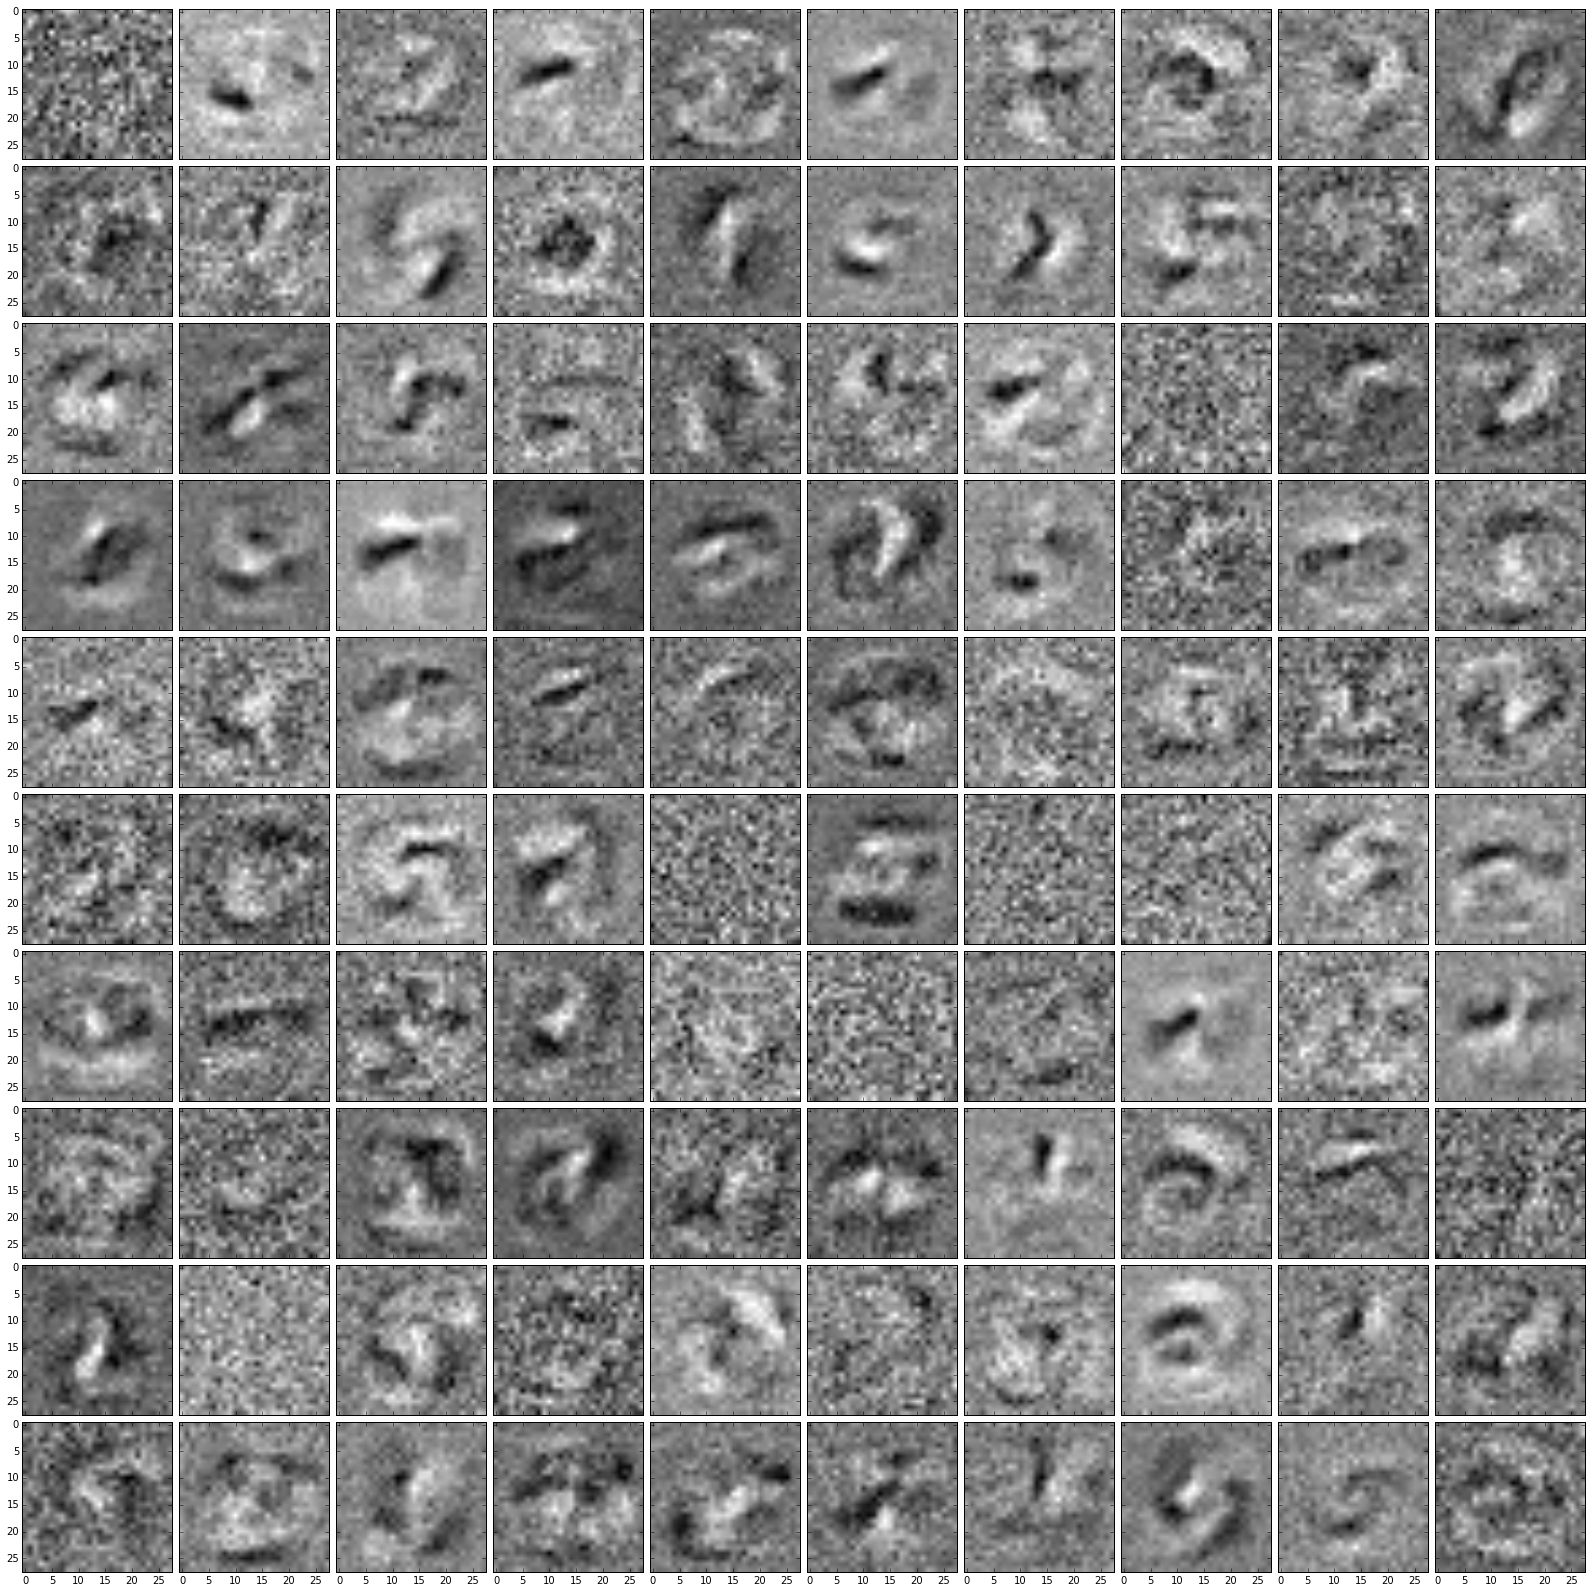

In [10]:
fig = plt.figure(1, (28., 28.))
grid = ImageGrid(fig, 111, nrows_ncols = (10, 10), axes_pad=0.1)

for i in range(100):
    image_array = dense_layer.W.get_value()[:, i].reshape((28, 28))
    grid[i].imshow(image_array, cmap=plt.cm.gray)